<a href="https://colab.research.google.com/github/sarithamiryala/DeepLearningClassifier/blob/main/Ensembed_Sugarcane_image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

akilesh253_sugarcane_plant_diseases_dataset_path = kagglehub.dataset_download('akilesh253/sugarcane-plant-diseases-dataset')
saritham_sugarcane_vit_model_pytorch_default_1_path = kagglehub.model_download('saritham/sugarcane_vit_model/PyTorch/default/1')
saritham_swintransformer_sugarcane_pytorch_default_1_path = kagglehub.model_download('saritham/swintransformer_sugarcane/PyTorch/default/1')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install split-folders

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

input_folder = "/kaggle/input/sugarcane-plant-diseases-dataset/Sugarcane_leafs"
splitfolders.ratio(input_folder, output="/kaggle/working/sugarcanedisease", seed=42, ratio=(0.7, 0.15, 0.15), group_prefix=None)

Copying files: 19926 files [03:37, 91.46 files/s] 


1. Load the Pretrained Models

In [ ]:
# Import standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformer models
from transformers import ViTForImageClassification, SwinForImageClassification

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
import torch
from transformers import ViTForImageClassification, SwinForImageClassification

# Paths to the saved model weights
vit_model_path = '/kaggle/input/sugarcane_vit_model/pytorch/default/1/vit_sugarcane_disease_detection.pth'
swin_model_path = '/kaggle/input/swintransformer_sugarcane/pytorch/default/1/swin_sugarcane_disease_detection.pth'

# Load ViT model
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=6,  # Ensure num_labels is set correctly
    ignore_mismatched_sizes=True  # Add if necessary
)
vit_model.load_state_dict(torch.load(vit_model_path, map_location=device))
vit_model.to(device)
vit_model.eval()

# Load Swin Transformer model
swin_model = SwinForImageClassification.from_pretrained(
    'microsoft/swin-base-patch4-window7-224',
    num_labels=6,
    ignore_mismatched_sizes=True
)
swin_model.load_state_dict(torch.load(swin_model_path, map_location=device))
swin_model.to(device)
swin_model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-773fa0a62871>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(

In [ ]:
import os
import torch
from torchvision import datasets, transforms

# Define data directories
data_dir = '/kaggle/working/sugarcanedisease'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Define data transformations
# Corresponding to Keras ImageDataGenerator parameters
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.RandomRotation(90),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
        transforms.ToTensor(),
        # No need for rescale=1./255 because ToTensor() does that
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        # No need for rescale=1./255 because ToTensor() does that
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        # No need for rescale=1./255 because ToTensor() does that
    ]),
}

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
import torch.nn.functional as F

def ensemble_predict(inputs):
    # Get outputs from ViT model
    vit_outputs = vit_model(inputs).logits  # Shape: [batch_size, num_classes]

    # Get outputs from Swin Transformer model
    swin_outputs = swin_model(inputs).logits  # Shape: [batch_size, num_classes]

    # Apply softmax to get probabilities
    vit_probs = F.softmax(vit_outputs, dim=1)
    swin_probs = F.softmax(swin_outputs, dim=1)

    # Average the probabilities
    avg_probs = (vit_probs + swin_probs) / 2

    # Get the final predictions
    _, ensemble_preds = torch.max(avg_probs, dim=1)

    return ensemble_preds, avg_probs

In [ ]:
# Initialize counters
ensemble_correct = 0
total_samples = 0

# Keep track of all labels and predictions for metrics
all_labels = []
all_preds = []

model_outputs = []

# Evaluation loop
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating Ensemble'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get ensemble predictions
        ensemble_preds, avg_probs = ensemble_predict(inputs)

        # Update counters
        ensemble_correct += (ensemble_preds == labels).sum().item()
        total_samples += labels.size(0)

        # Collect labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(ensemble_preds.cpu().numpy())
        model_outputs.extend(avg_probs.cpu().numpy())

# Calculate accuracy
ensemble_accuracy = ensemble_correct / total_samples
print(f'Ensemble Model Accuracy: {ensemble_accuracy:.4f}')

Evaluating Ensemble: 100%|██████████| 188/188 [01:23<00:00,  2.25it/s]

Ensemble Model Accuracy: 0.9696


                  precision    recall  f1-score   support

BacterialBlights       0.98      1.00      0.99       720
         Healthy       0.98      0.96      0.97       471
          Mosaic       0.96      0.97      0.96       417
          RedRot       0.98      0.96      0.97       467
            Rust       0.95      0.98      0.96       464
          Yellow       0.96      0.94      0.95       455

        accuracy                           0.97      2994
       macro avg       0.97      0.97      0.97      2994
    weighted avg       0.97      0.97      0.97      2994



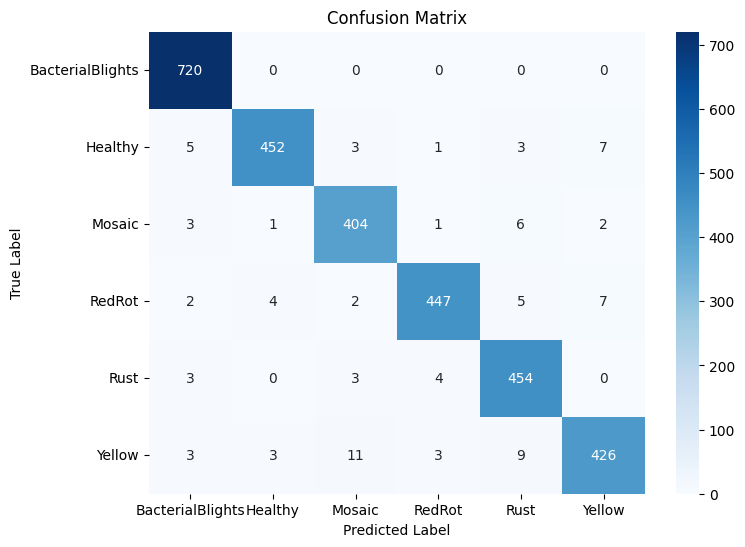

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
print(report)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes,
            cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

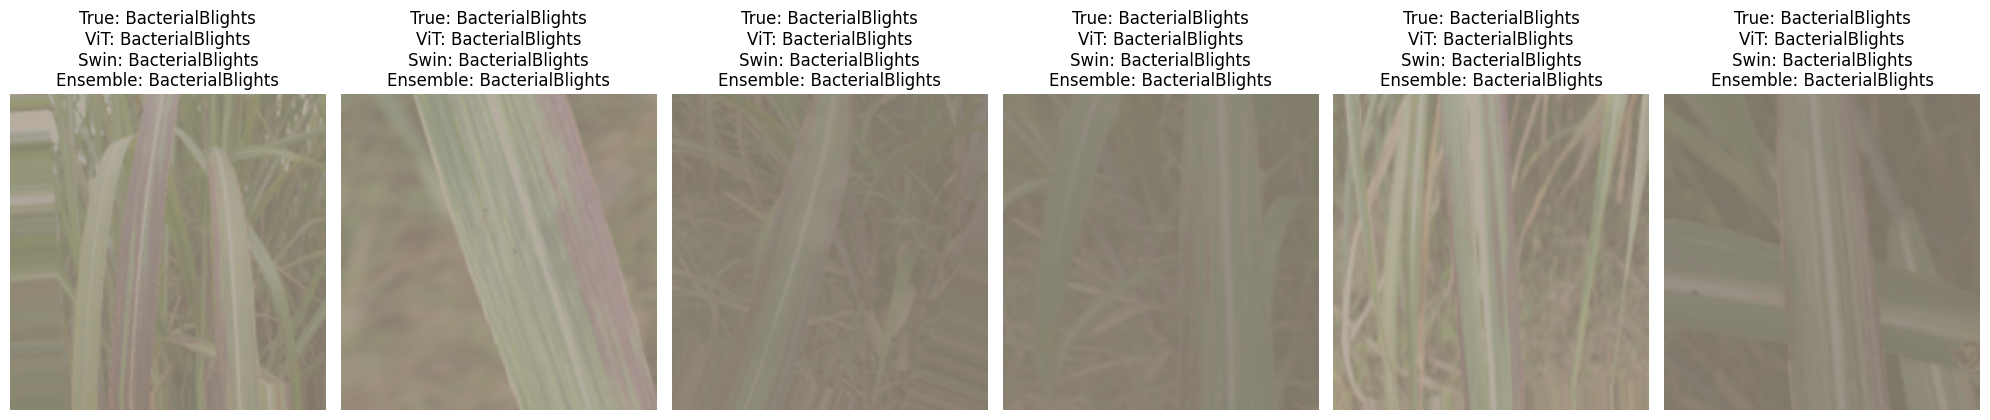

In [ ]:
def imshow(inp, title=None):
    """Show image for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    # Unnormalize
    inp = inp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch from the test loader
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Get individual and ensemble predictions
with torch.no_grad():
    # ViT predictions
    vit_outputs = vit_model(inputs).logits
    vit_probs = F.softmax(vit_outputs, dim=1)
    _, vit_preds = torch.max(vit_probs, dim=1)

    # Swin Transformer predictions
    swin_outputs = swin_model(inputs).logits
    swin_probs = F.softmax(swin_outputs, dim=1)
    _, swin_preds = torch.max(swin_probs, dim=1)

    # Ensemble predictions
    ensemble_preds, _ = ensemble_predict(inputs)

# Move data to CPU for visualization
inputs = inputs.cpu()
labels = labels.cpu()
vit_preds = vit_preds.cpu()
swin_preds = swin_preds.cpu()
ensemble_preds = ensemble_preds.cpu()

# Class names
class_names = test_dataset.classes

# Number of images to display
num_images = 6

# Plot the images with predictions
fig = plt.figure(figsize=(20, 5))
for idx in range(num_images):
    ax = fig.add_subplot(1, num_images, idx+1)
    imshow(inputs[idx])
    true_label = class_names[labels[idx]]
    vit_label = class_names[vit_preds[idx]]
    swin_label = class_names[swin_preds[idx]]
    ensemble_label = class_names[ensemble_preds[idx]]

    # Customize the title to show true and predicted labels
    ax.set_title(f'True: {true_label}\nViT: {vit_label}\nSwin: {swin_label}\nEnsemble: {ensemble_label}')
    ax.axis('off')
plt.tight_layout()
plt.show()